In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
import openai
from dotenv import load_dotenv
from IPython.display import Markdown, display
load_dotenv()

# This requires you to either set OPENAI_API_KEY environment variable or
# create a .env file in the same directory as this notebook with this variable
openai.api_key = os.getenv("OPENAI_API_KEY")
np.random.seed(0)

from gptcellannotator import *

This notebook uses processed data from the E14 sample of the [GSE101099](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE101099) dataset.

    Byrnes, L.E., Wong, D.M., Subramaniam, M. et al. Lineage dynamics of murine pancreatic development at single-cell resolution. Nat Commun 9, 3922 (2018). https://doi.org/10.1038/s41467-018-06176-3

## Query expected cell types and their markers

Generate a list of cell types and their markers:

In [195]:
expected_types, expected_markers = get_expected_cell_types(
    species='mouse', tissue='pancreas', model='gpt-4', max_tokens=800
)

Querying cell types...
Querying cell type markers...
Done!


In [226]:
display(Markdown(expected_types))

The pancreas contains several different cell types that function in both the exocrine and endocrine systems. Here's an unordered list of various cell types you can expect to find in the mouse pancreas:

Exocrine cells:
- Acinar cells
  - Zymogen-producing cells (enzymes for digestion)

- Ductal cells
  - Intercalated duct cells
  - Intralobular duct cells
  - Interlobular duct cells

Endocrine cells (found in the Islets of Langerhans):
- Alpha cells (produce glucagon)
- Beta cells (produce insulin)
- Delta cells (produce somatostatin)
- PP or F (gamma) cells (produce pancreatic polypeptide)
- Epsilon cells (produce ghrelin)

Stromal cells (support the structure and function of the pancreas):
- Endothelial cells (form blood vessels)
- Pericytes (support blood vessels)
- Smooth muscle cells (in blood vessels)
- Fibroblasts (secrete collagen and other extracellular matrix components)
- Macrophages and other immune cells (such as dendritic cells and T cells)

These various cell types play important roles in the exocrine and endocrine functions of the pancreas, which is central to digestion and glucose homeostasis within the mouse organism.

In [227]:
display(Markdown(expected_markers))

- Acinar cells: Ptf1a, Pnlip, Cpa1, Amy2a, Ctrb1
- Intercalated duct cells: Krt19, Cftr, Foxq1, Ca2, Aqp5
- Intralobular duct cells: Krt7, Krt19, Clca1, Cftr, Ca2
- Interlobular duct cells: Sox9, Krt19, Muc13, Cftr, Clca1

- Alpha cells: Gcg, Arx, Irx2, Mafb, Sostdc1
- Beta cells: Ins1, Ins2, Pdx1, Neurod1, Foxa2
- Delta cells: Sst, Hhex, Ucn3, Isl1, Pax6
- PP or F (gamma) cells: Ppy, Nkx2-2, Pax4, Iapp, Isl1
- Epsilon cells: Ghrl, Nkx2-2, Pax4, Islet1, Mlxipl

- Endothelial cells: Pecam1, Flk1, Vecad, Vwf, Tie1
- Pericytes: Pdgfrb, Rgs5, Apln, Cspg4, Abcc9
- Smooth muscle cells: Acta2, Myh11, Tagln, Sm22, Des
- Fibroblasts: Pdgfra, Col1a1, Col1a2, Vimentin, Fsp1
- Macrophages: Cd68, F4/80, Csf1r, Cd11b, Cd163
- Dendritic cells: Cd11c, Cd45, Mhc2, Cd80, Cd86
- T cells: Cd3, Cd4, Cd8, Tcrb, Cd28

## Load data

/Users/vpetukhov/other/LLMs/GPTCellTypes/env/lib/python3.9/site-packages/umap/distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/vpetukhov/other/LLMs/GPTCellTypes/env/lib/python3.9/site-packages/umap/distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/vpetukhov/other/LLMs/GPTCellTypes/env/lib/pyt

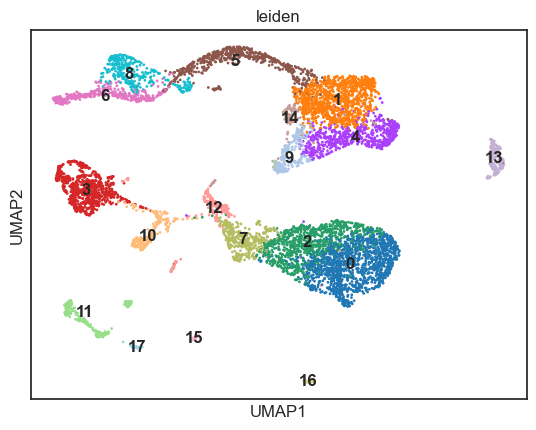

In [ ]:
ad = sc.read_h5ad("../data/mouse_pancreas/E14.h5ad")
sc.pp.neighbors(ad, n_neighbors=30)
sc.tl.leiden(ad, resolution=0.8)
sc.pl.umap(ad, color=['leiden'], legend_loc='on data')
# del ad.uns['log1p']

In [ ]:
del ad.uns['log1p']

Find marker genes for each cluster:

In [ ]:
marker_dfs = get_markers_per_cluster(ad, clustering='leiden')

  0%|          | 0/18 [00:00<?, ?it/s]

Filter these markers:

0.7536115743435646


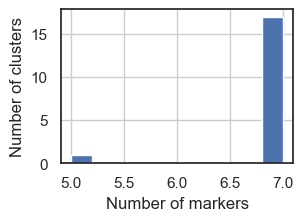

In [ ]:
print(marker_dfs.map(lambda x: x.auc.max()).min())
marker_genes = get_top_markers(marker_dfs, min_auc=0.7)

marker_genes.map(len).hist(figsize=(3, 2))
plt.xlabel('Number of markers'); plt.ylabel('Number of clusters');

## Annotate clusters

In [228]:
annotation_res = annotate_clusters(
    marker_genes, species='mouse', tissue='pancreas', expected_markers=expected_markers, 
    # model='gpt-3.5-turbo'
    model='gpt-4'
)

  0%|          | 0/18 [00:00<?, ?it/s]

Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))


In [222]:
ann_df = parse_annotation(annotation_res)
ann_df

,Marker description,Cell type,Cell state,Confidence,Reason,"Cell type, raw"
0,Ptf1a is a transcription factor expressed in p...,Acinar,Normal.,medium,The expression of Ptf1a is strongly indicative...,Acinar cells.
1,Marker 1700011H14Rik is a protein-coding gene ...,Interlobular duct,Normal,medium,"The markers Tmem45a, Pdzk1ip1 and Bicc1 are no...",Interlobular duct cells
2,Ptf1a is a transcription factor that is specif...,Acinar,Normal,high,Ptf1a is a well-known marker for acinar cells ...,Acinar cell
3,"S100a6, Dcn, Igfbp2, Prkcdbp, Cryab, Igfbp5, R...",Fibroblasts,Normal,medium,"The presence of the fibroblast markers Dcn, Cr...",Fibroblasts
4,Nr4a1 is an orphan nuclear receptor and a tran...,Macrophages,normal,medium,The markers are not specific to macrophages an...,Macrophages
5,Neurog3 is a transcription factor that is a ma...,Endocrine progenitor,Normal,medium,While Neurog3 is a master regulator of endocri...,Endocrine progenitor cells
6,Chgb and Chga are commonly used markers for ma...,Neuroendocrine,Normal.,high,Chgb and/or Chga are commonly used markers for...,"Neuroendocrine cells (specifically, chromaffin..."
7,These markers are associated with cell divisio...,Proliferating,Normal.,high,The markers are all associated with the cell c...,Proliferating cells (could be any of the cell ...
8,"Isl1, Scg5, Pcsk1n are markers for mature endo...",Endocrine,Normal,high,The markers are specifically expressed in endo...,Endocrine cells
9,"Top2a, Prc1, and Nusap1 are associated with ce...",Unknown,Unknown,low,The markers are not definitive for any specifi...,Unknown


- 'Fibroblasts' are cancer cells

/Users/vpetukhov/other/LLMs/GPTCellTypes/env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


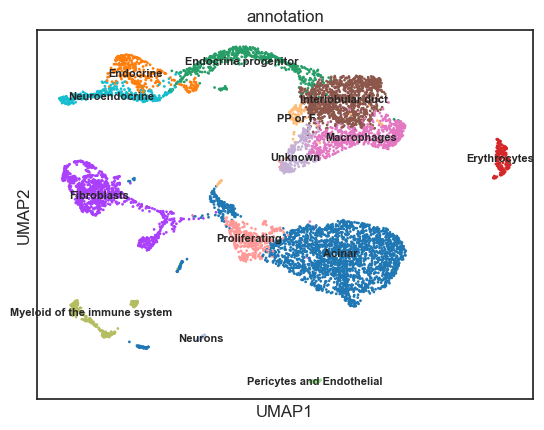

In [223]:
ad.obs['annotation'] = ann_df['Cell type'][ad.obs['leiden'].values.astype(int)].values
sc.pl.umap(ad, color=['annotation'], legend_loc='on data', legend_fontsize=8)